In [2]:
# auto-reload modules
%load_ext autoreload
%autoreload 2

In [3]:
import os
# change working directory 
if os.getcwd().split("/")[-1] != "ada-2024-project-c1n3mada":
    os.chdir("..")

### Q.4 How does a movie's genre impact its box office revenue? 

This question aims to understand if certain genres are associated with higher revenues and if the relationship between genre and revenue changes over time.

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate
from src.utils.plot_utils import revenue_formatter

In [5]:
df_movies = pd.read_csv('data/movies_combined_inflated.csv')

# print the number of rows
print('Number of movies:', len(df_movies))

Number of movies: 9579


#### 0. Initial analysis

Before addressing our research question, it's important to familiarize ourselves with the dataset. To do this, we aim to answer the following questions:

- How many different genres are there in our dataset? 
- How many movies are there per genre?
- How many movies are categorized under more than one genre?

In [6]:
# convert string to list of genres
df_movies["movie_genres"] = df_movies["movie_genres"].apply(
    lambda x: [t[1] for t in eval(x)]
)

In [7]:
# get all unique genres across all movies
all_genres = set()
for genres in df_movies["movie_genres"]:
    all_genres.update(genres)

print(f"Number of unique genres: {len(all_genres)}")
print("Unique genres:")
print(sorted(all_genres))

Number of unique genres: 317
Unique genres:
['Absurdism', 'Acid western', 'Action', 'Action Comedy', 'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult', 'Adventure', 'Adventure Comedy', 'Airplanes and airports', 'Albino bias', 'Alien Film', 'Alien invasion', 'Americana', 'Animal Picture', 'Animals', 'Animated Musical', 'Animated cartoon', 'Animation', 'Anime', 'Anthology', 'Anthropology', 'Anti-war', 'Anti-war film', 'Apocalyptic and post-apocalyptic fiction', 'Archaeology', 'Archives and records', 'Art film', 'Auto racing', 'Avant-garde', 'B-Western', 'B-movie', 'Backstage Musical', 'Baseball', 'Beach Film', 'Bengali Cinema', 'Biker Film', 'Biographical film', 'Biography', 'Biopic [feature]', 'Black comedy', 'Black-and-white', 'Blaxploitation', 'Bloopers & Candid Camera', 'Bollywood', 'Boxing', 'Breakdance', 'British Empire Film', 'British New Wave', 'Buddy cop', 'Buddy film', 'Business', 'Camp', 'Caper story', 'Cavalry Film', 'Chase Movie', 'Childhood Drama', "Childre

In [64]:
# count number of movies per genre
genre_count = {}
for genres in df_movies["movie_genres"]:
    for genre in genres:
        if genre not in genre_count:
            genre_count[genre] = 0
        genre_count[genre] += 1

# convert to dataframe and sort by count
genre_df = pd.DataFrame.from_dict(genre_count, orient='index', columns=['count'])
genre_df = genre_df.sort_values('count', ascending=False)

print("Number of movies per genre:")
print(tabulate(genre_df, headers='keys', tablefmt='psql'))

Number of movies per genre:
+------------------------------------------+---------+
|                                          |   count |
|------------------------------------------+---------|
| Drama                                    |    5014 |
| Comedy                                   |    3516 |
| Romance Film                             |    2302 |
| Thriller                                 |    2265 |
| Action                                   |    2027 |
| Action/Adventure                         |    1553 |
| Crime Fiction                            |    1503 |
| Adventure                                |    1316 |
| Indie                                    |    1229 |
| Romantic comedy                          |     973 |
| Family Film                              |     925 |
| Romantic drama                           |     884 |
| Horror                                   |     875 |
| World cinema                             |     808 |
| Fantasy                            

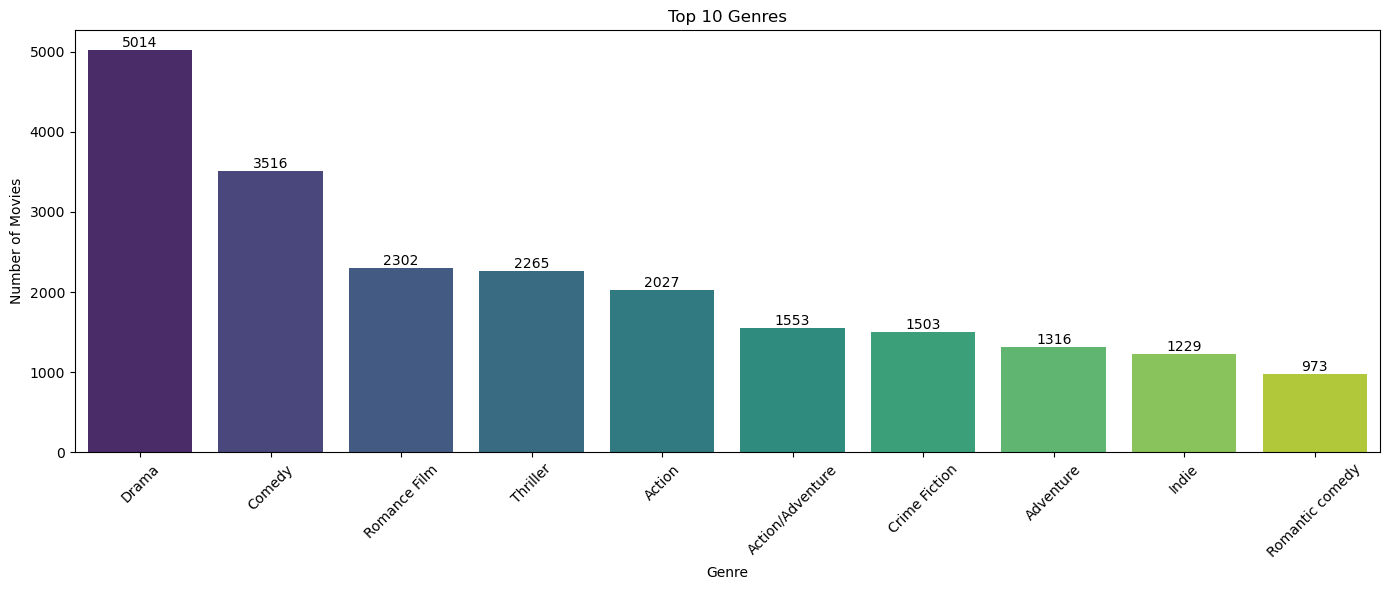

In [9]:
# plot top 10 most common genres as a bar plot
top_10_genres = genre_df.head(10)
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=top_10_genres.index, y=top_10_genres['count'], hue=top_10_genres.index, palette="viridis")
# add the number of movies above each bar
for i, v in enumerate(top_10_genres['count']):
    ax.text(i, v, str(int(v)), ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title("Top 10 Genres")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

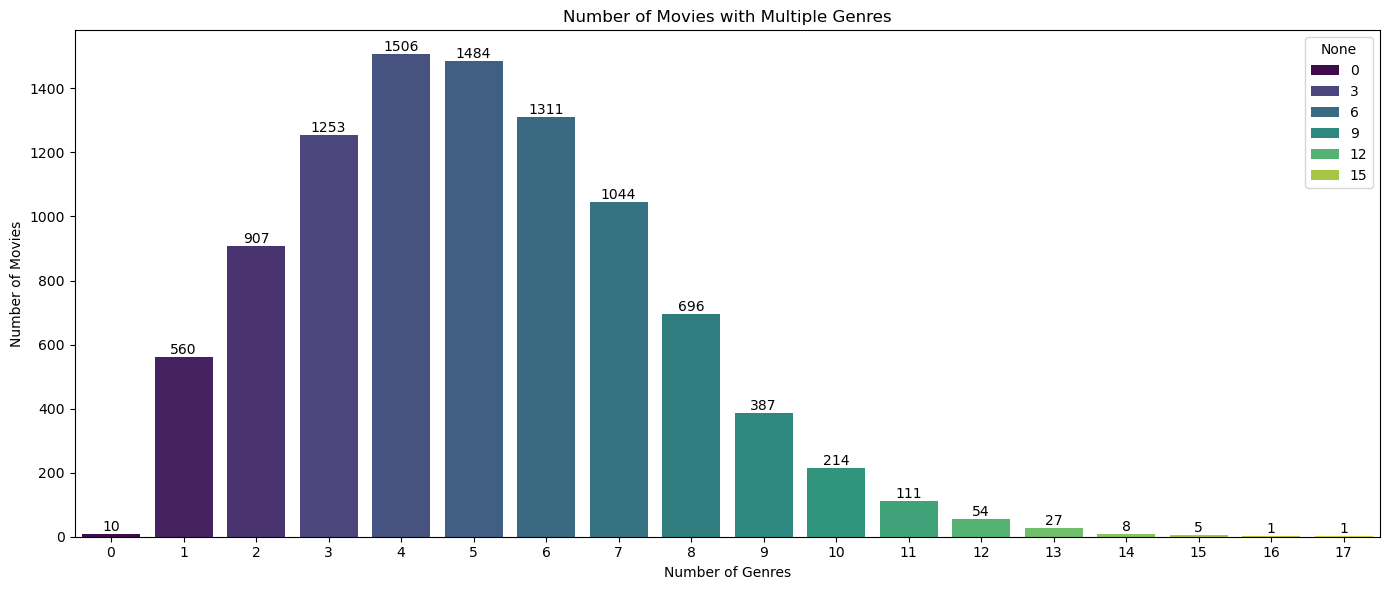

In [10]:
# count the movies with multiple genres
multi_genre_counts = {}
for genres in df_movies["movie_genres"]:
    if len(genres) not in multi_genre_counts:
        multi_genre_counts[len(genres)] = 0
    multi_genre_counts[len(genres)] += 1

# convert to dataframe and sort by count
multi_genre_df = pd.DataFrame.from_dict(multi_genre_counts, orient='index', columns=['count'])
multi_genre_df = multi_genre_df.sort_index()

# plot number of movies with multiple genres as a bar plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=multi_genre_df.index, y=multi_genre_df['count'], hue=multi_genre_df.index, palette="viridis")
# add the number of movies above each bar
for i, v in enumerate(multi_genre_df['count']):
    ax.text(i, v, str(int(v)), ha='center', va='bottom')
plt.title("Number of Movies with Multiple Genres")
plt.xlabel("Number of Genres")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

In [11]:
# print the percentage of movies with more than one genre
percentage = (len(df_movies)-multi_genre_counts[1])/len(df_movies)*100
print(f"Percentage of movies with more than one genre: {percentage:.2f}%", )

Percentage of movies with more than one genre: 94.15%


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - There are 317 different genres in our dataset. 
  - The top 10 most common genres are: Drama, Comedy, Romance Film, Thriller, Action, Action/Adventure, Crime Fiction, Adventure, Indie and Romantic comedy.
  - 94.15 % of the movies have more than one genre.
</div>

Analyzing revenue patterns across all 317 genres in our dataset is impractical, so we will focus our analysis on the 10 most common genres.

In [12]:
# we will focus on the top 10 genres for the rest of the analysis
top_10_genres_list = genre_df.head(10).index.tolist()
print("Top 10 genres:")
print(top_10_genres_list)

# create a new dataframe with exploded genres, revenues and release years
df_genre_revenue = df_movies.explode('movie_genres')[['movie_genres', 'combined_revenue', 'release_year']]
# filter for only top-10 genres
df_genre_revenue = df_genre_revenue[df_genre_revenue['movie_genres'].isin(top_10_genres_list)]
print("\nNumber of rows in the new exploded dataframe:", len(df_genre_revenue))

Top 10 genres:
['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'Action/Adventure', 'Crime Fiction', 'Adventure', 'Indie', 'Romantic comedy']

Number of rows in the new exploded dataframe: 21698


<div class="alert alert-success">

  💭 <strong> Other ideas: </strong>
  
  - Should we also analyze the genre combinations, e.g. Drama + Romance?
  - Are movies with more than 1 genre more profitable?
  
</div>

#### 1. What are the average and median revenues for each genre?

This question aims to identify which genres tend to perform better financially and detect any clear outliers.

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Desctiptive statistics: mean, median, standard error of the mean
  - Visualization: bar plot
</div>

We will first compute the mean, median and standard error of the box office revenues for each of the top-10 genres.


In [67]:
# calculate average, median and standard error of the revenue per genre
genre_revenue_stats = df_genre_revenue.groupby('movie_genres').agg({
    'combined_revenue': ['mean', 'median', 'sem']
}).round(2)

# rename columns
genre_revenue_stats.columns = ['mean', 'median', 'sem']
# sort by mean revenue
genre_revenue_stats = genre_revenue_stats.sort_values('mean', ascending=False)

print("Revenue statistics by genre (in dollars):")
print(tabulate(genre_revenue_stats, headers='keys', tablefmt='psql'))

Revenue statistics by genre (in dollars):
+------------------+-------------+-------------+-------------+
| movie_genres     |        mean |      median |         sem |
|------------------+-------------+-------------+-------------|
| Adventure        | 1.13198e+08 | 2.71547e+07 | 5.88427e+06 |
| Action           | 8.37016e+07 | 2.06429e+07 | 3.70113e+06 |
| Action/Adventure | 7.20815e+07 | 1.81335e+07 | 3.47709e+06 |
| Thriller         | 6.44605e+07 | 1.87075e+07 | 2.74637e+06 |
| Comedy           | 4.73539e+07 | 1.32745e+07 | 1.64335e+06 |
| Crime Fiction    | 4.50889e+07 | 1.22816e+07 | 2.27451e+06 |
| Romance Film     | 3.94003e+07 | 9.46891e+06 | 1.84377e+06 |
| Romantic comedy  | 3.91201e+07 | 1.33959e+07 | 2.21412e+06 |
| Drama            | 3.64338e+07 | 7.30812e+06 | 1.26794e+06 |
| Indie            | 1.22505e+07 | 2.14772e+06 | 1.01654e+06 |
+------------------+-------------+-------------+-------------+


For better interpretation, we will also use a bar plot to vizualize the means and standard error for each genre.

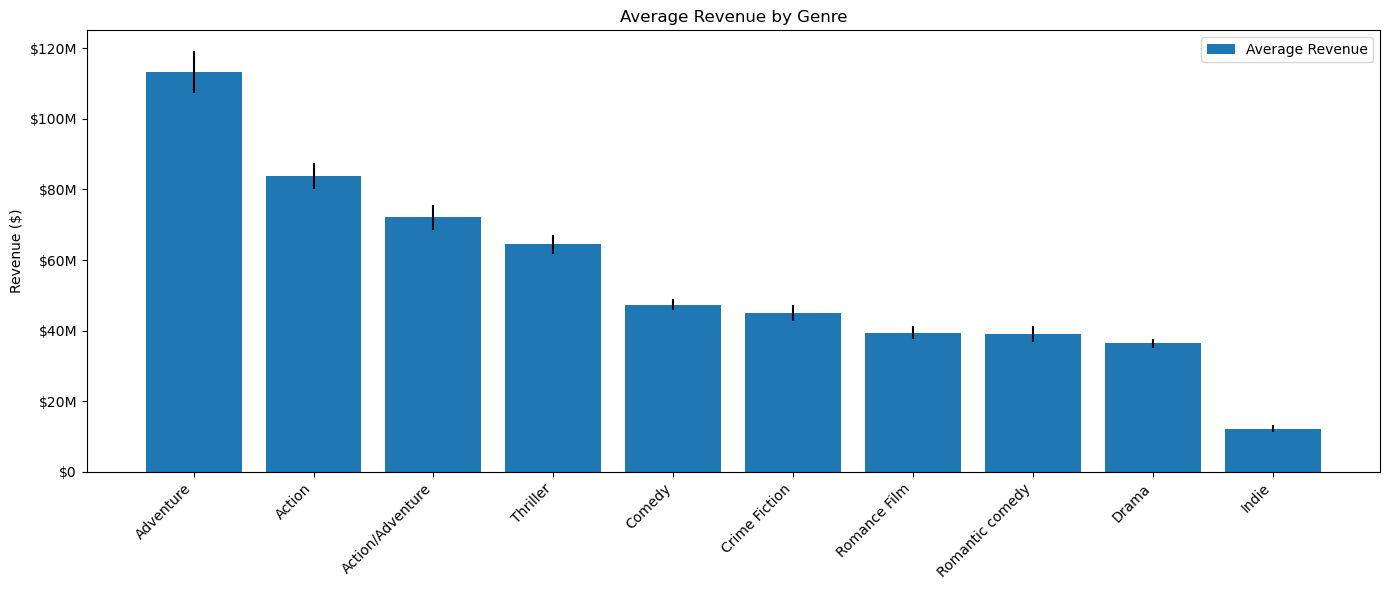

In [14]:
x = np.arange(len(genre_revenue_stats.index))
fig, ax = plt.subplots(figsize=(14, 6))
rects = ax.bar(x, genre_revenue_stats['combined_revenue', 'mean'], label='Average Revenue', yerr=genre_revenue_stats['combined_revenue', 'sem'])
ax.set_ylabel('Revenue ($)')
ax.set_title('Average Revenue by Genre')
ax.set_xticks(x)
ax.set_xticklabels(genre_revenue_stats.index, rotation=45, ha='right')
ax.legend()
# format y-axis to use dollars
ax.yaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - **Drama** is the most popular genre, appearing in 5042 movies. However, ranked by average revenue it is on the 9-th spot.
</div>

#### 2. What is the distribution of revenues within each genre? Are there high variability and skewness?

This question aims to explore if specific genres have wider distributions in revenue, indicating higher financial risk or reward. 

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

  - Descriptive statistics: interquartile range, variance and skewness
  - Visualization: box plot or violin plot
</div>

In [68]:
# calculate interquartile range, variance and skewness for each genre
genre_revenue_stats = df_genre_revenue.groupby('movie_genres')['combined_revenue'].agg(['min', 'max', 'mean', 'median', 'std', 'var', 'skew']).round(2)
print("Revenue statistics by genre (in dollars):")
print(tabulate(genre_revenue_stats, headers='keys', tablefmt='psql'))

Revenue statistics by genre (in dollars):
+------------------+-------+-------------+-------------+-------------+-------------+-------------+--------+
| movie_genres     |   min |         max |        mean |      median |         std |         var |   skew |
|------------------+-------+-------------+-------------+-------------+-------------+-------------+--------|
| Action           |     1 | 2.78797e+09 | 8.37016e+07 | 2.06429e+07 | 1.66633e+08 | 2.77665e+16 |   5.02 |
| Action/Adventure |     1 | 1.84503e+09 | 7.20815e+07 | 1.81335e+07 | 1.37026e+08 | 1.8776e+16  |   4.3  |
| Adventure        |     1 | 2.78797e+09 | 1.13198e+08 | 2.71547e+07 | 2.13462e+08 | 4.55659e+16 |   3.8  |
| Comedy           |     1 | 1.06697e+09 | 4.73539e+07 | 1.32745e+07 | 9.7444e+07  | 9.49533e+15 |   4.4  |
| Crime Fiction    |     1 | 1.08494e+09 | 4.50889e+07 | 1.22816e+07 | 8.81796e+07 | 7.77564e+15 |   4.42 |
| Drama            |     1 | 1.84503e+09 | 3.64338e+07 | 7.30812e+06 | 8.97822e+07 | 8.06084e+

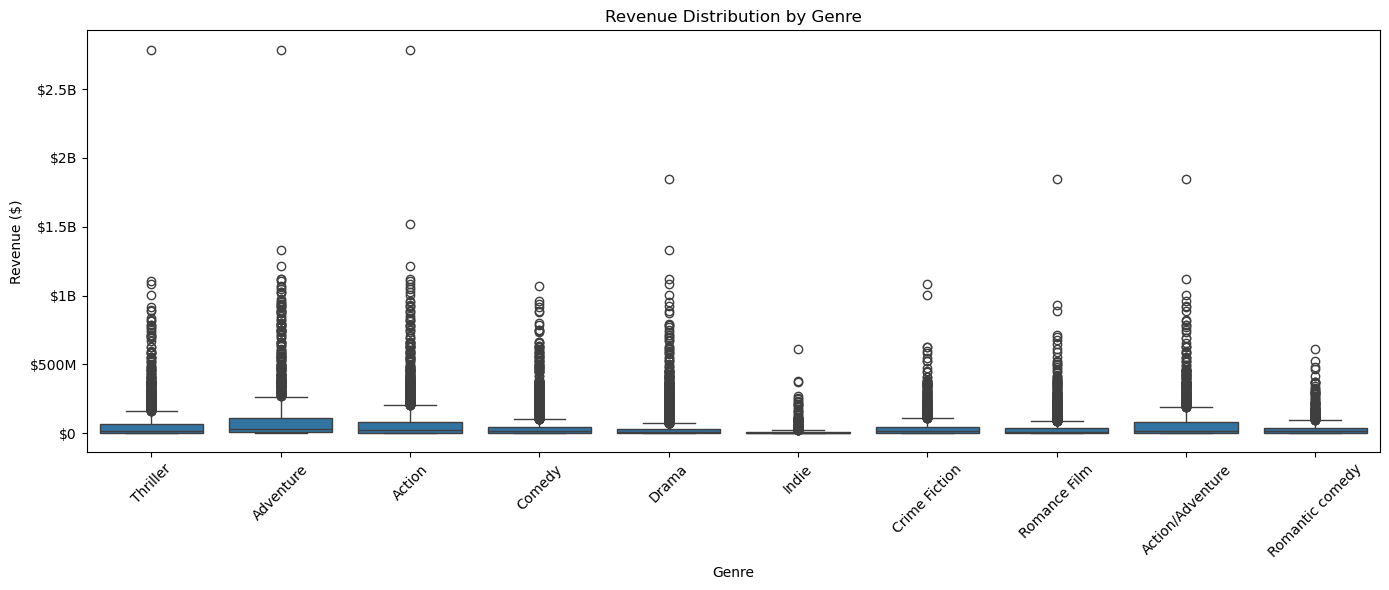

In [25]:
# plot box plots for each genre
plt.figure(figsize=(14, 6))
sns.boxplot(x='movie_genres', y='combined_revenue', data=df_genre_revenue, showfliers=True) # TODO: when True the outliers are shown (doesn't look good)
plt.xticks(rotation=45)
plt.title('Revenue Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Revenue ($)')
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
</div>


#### 3. How has the revenue of each genre changed over time?

This question aims to answer whether certain genres have more (or less) popular or profitable over time.

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

  - Visualization: Line plot
</div>

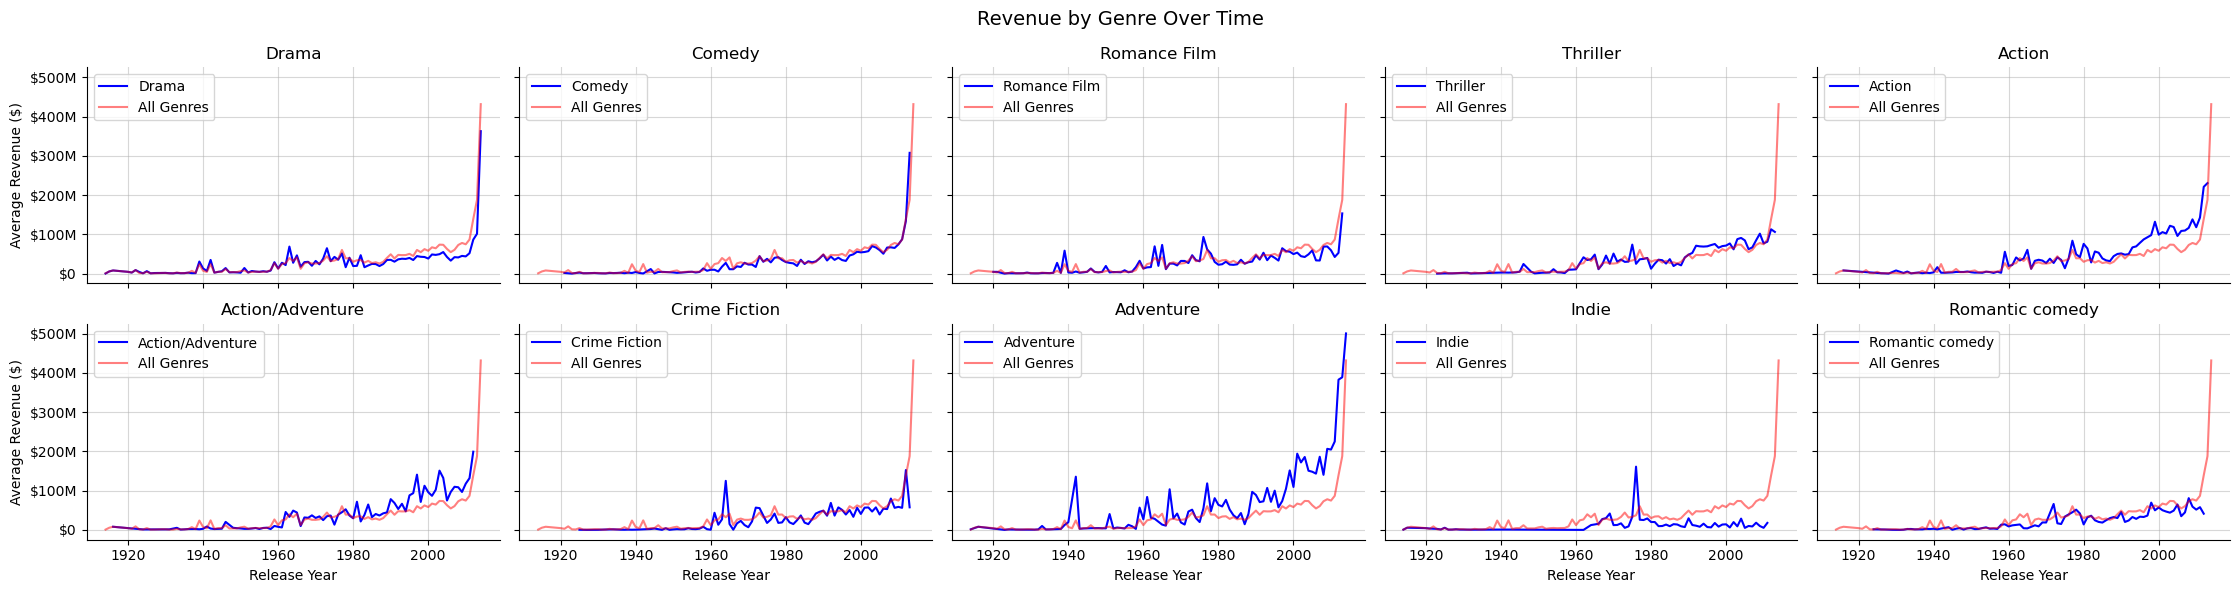

In [90]:
# calculate average revenue by year
year_avg_revenue = df_genre_revenue.groupby('release_year')['combined_revenue'].mean().reset_index()
# calculate average revenue by genre and year
genre_year_avg_revenue = df_genre_revenue.groupby(['movie_genres', 'release_year'])['combined_revenue'].mean().reset_index()

# create a facet grid of line plots for each genre
g = sns.FacetGrid(data=genre_year_avg_revenue, col='movie_genres', col_wrap=5, height=3, aspect=1.5)

for ax, genre in zip(g.axes, top_10_genres_list):
    revenue_data = genre_year_avg_revenue[genre_year_avg_revenue['movie_genres'] == genre]
    ax.plot(revenue_data['release_year'], revenue_data['combined_revenue'], color='blue', label=f'{genre}')
    ax.plot(year_avg_revenue['release_year'], year_avg_revenue['combined_revenue'], color='red', alpha=0.5, label='All Genres')
    ax.set_xlabel('Release Year')
    ax.set_ylabel('Average Revenue ($)')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))
    ax.tick_params(axis='y')
    ax.grid(True, alpha=0.5)
    ax.set_title(genre)
    ax.legend(loc='upper left')

plt.suptitle('Revenue by Genre Over Time', fontsize=14)
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

</div>


#### 4. Are there any trends in genre popularity over time, and how do they correlate with revenue changes?

This question aims to determine if changes in revenue for a genre correspond with changes in the number of movies produced in that genre.


<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

  - Visualization: Line plot
  - Correlation coefficient: Pearson and Spearman

</div>

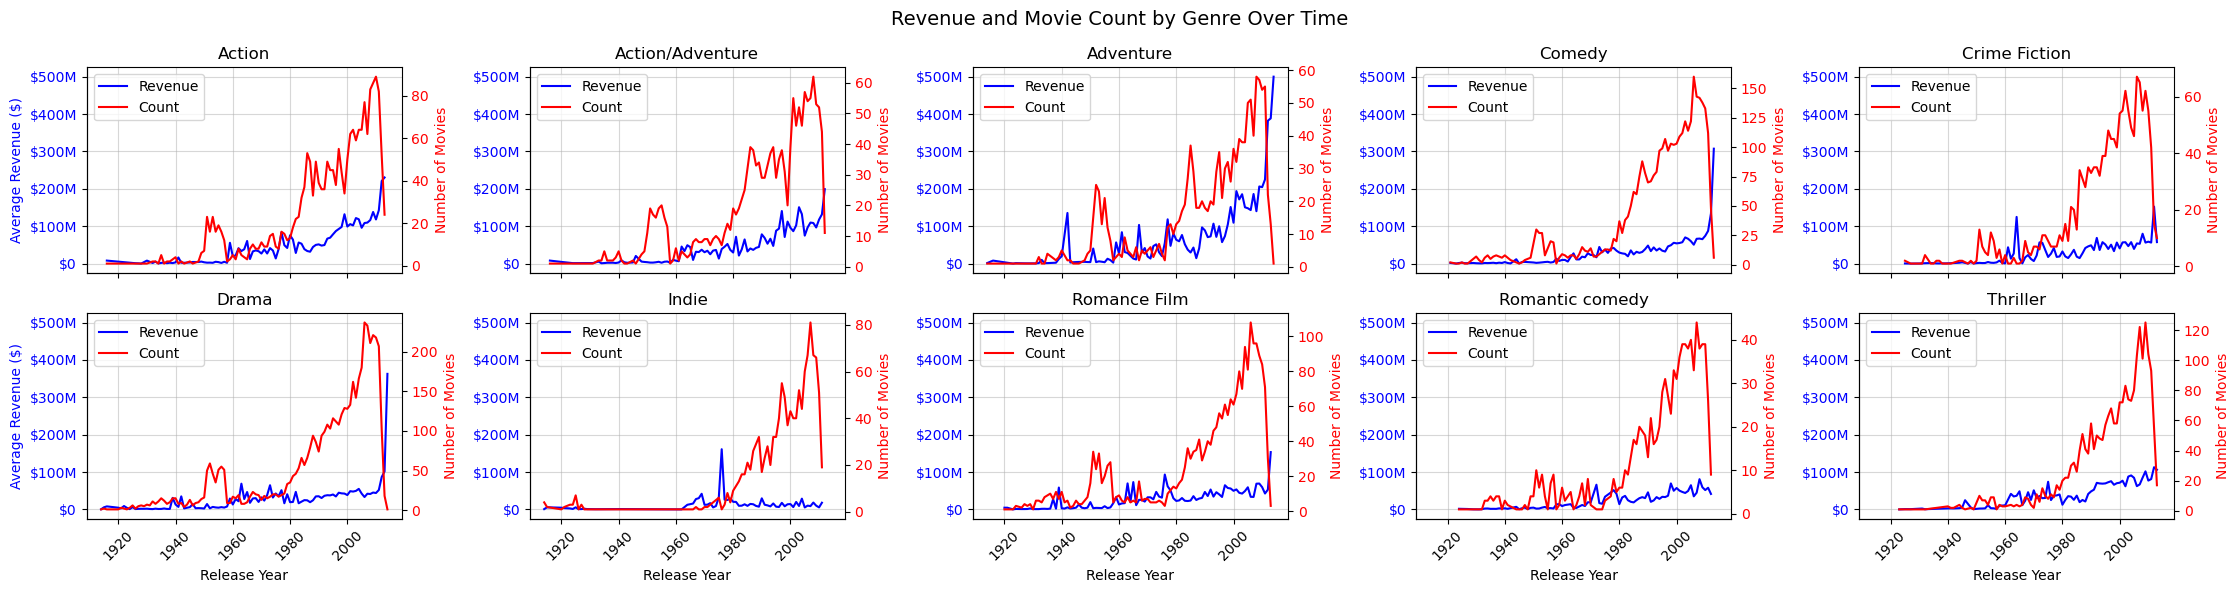

In [39]:
# TODO: Is it a good idea to only count movies that have a revenue? 
# TODO: Explain the drop in the number of movies after 2000. 

# calculate number of movies per genre per year
genre_year_counts = df_genre_revenue.groupby(['movie_genres', 'release_year']).size().reset_index(name='count')
# create a facet grid of line plots for each genre
g = sns.FacetGrid(data=genre_year_avg_revenue, col='movie_genres', col_wrap=5, height=3, aspect=1.5)

# plot revenue on primary y-axis
for ax, genre in zip(g.axes, genre_year_avg_revenue['movie_genres'].unique()):
    # revenue plot
    revenue_data = genre_year_avg_revenue[genre_year_avg_revenue['movie_genres'] == genre]
    ax1 = ax
    ln1 = ax1.plot(revenue_data['release_year'], revenue_data['combined_revenue'], color='blue', label='Revenue')
    ax1.set_xlabel('Release Year')
    ax1.set_ylabel('Average Revenue ($)', color='blue')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # number of movies plot
    ax2 = ax1.twinx()
    count_data = genre_year_counts[genre_year_counts['movie_genres'] == genre]
    ln2 = ax2.plot(count_data['release_year'], count_data['count'], color='red', label='Count')
    ax2.set_ylabel('Number of Movies', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # formatting
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.5)
    ax.set_title(genre)
    
    # legend
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper left')

plt.suptitle('Revenue and Movie Count by Genre Over Time', fontsize=14)
plt.tight_layout()
plt.show()

In [71]:
results = [] # empty list to store the results
for genre in top_10_genres_list:
    # extract average revenue for the genre
    genre_average_revenue = genre_year_avg_revenue[genre_year_avg_revenue['movie_genres'] == genre]['combined_revenue']
    # extract number of movies for the genre
    genre_count = genre_year_counts[genre_year_counts['movie_genres'] == genre]['count']
    # calculate Pearson and Spearman correlation coefficients
    pearson_correlation, pearson_p_value = stats.pearsonr(genre_average_revenue, genre_count)
    spearman_correlation, spearman_p_value = stats.spearmanr(genre_average_revenue, genre_count)
    # append the results to the list
    results.append({
        'Genre': genre,
        'Pearson Correlation': f"{pearson_correlation:.2f}",
        'Pearson p-value': f"{pearson_p_value:.2f}",
        'Spearman Correlation': f"{spearman_correlation:.2f}",
        'Spearman p-value': f"{spearman_p_value:.2f}"
    })

# convert the list of results to a dataframe
correlation_df = pd.DataFrame(results)
print(tabulate(correlation_df, headers='keys', tablefmt='psql', showindex=False))

+------------------+-----------------------+-------------------+------------------------+--------------------+
| Genre            |   Pearson Correlation |   Pearson p-value |   Spearman Correlation |   Spearman p-value |
|------------------+-----------------------+-------------------+------------------------+--------------------|
| Drama            |                  0.19 |              0.06 |                   0.62 |               0    |
| Comedy           |                  0.43 |              0    |                   0.8  |               0    |
| Romance Film     |                  0.42 |              0    |                   0.55 |               0    |
| Thriller         |                  0.76 |              0    |                   0.79 |               0    |
| Action           |                  0.74 |              0    |                   0.79 |               0    |
| Action/Adventure |                  0.72 |              0    |                   0.75 |               0    |
|

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

</div>